In [3]:
import sys
if ".." not in sys.path:
    sys.path.insert(0, "..")

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from cobra.sampling import OptGPSampler
from scipy.linalg import null_space
from scipy.sparse.linalg import spsolve, eigs
from cobra.io import read_sbml_model
from utils.cobra_utils import get_or_create_exchange
from tqdm import tqdm
from warnings import catch_warnings

MODEL_FILE = "../model/Rpom_05.xml"
BIOMASS_ID = "Rpom_hwa_biomass"
DATA_FILE = "../data/clean/CUE2/dFBA.pkl"


# Load and set up model
model = read_sbml_model(MODEL_FILE)

# Set maintenance to 25 mmol/gDW/h
atpm = model.reactions.get_by_id("ATPM")
# atpm.bounds = (25, 25)

ex_glc = model.reactions.get_by_id("EX_glc")
ex_ace = get_or_create_exchange(model, "ACET[e]")

https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http(s)://identifiers.org/collection/id' or'http(s)://identifiers.org/COLLECTION:id
https://identifiers.org/stem/ does not conform to 'http

100%|██████████| 5000/5000 [00:54<00:00, 91.66it/s] 


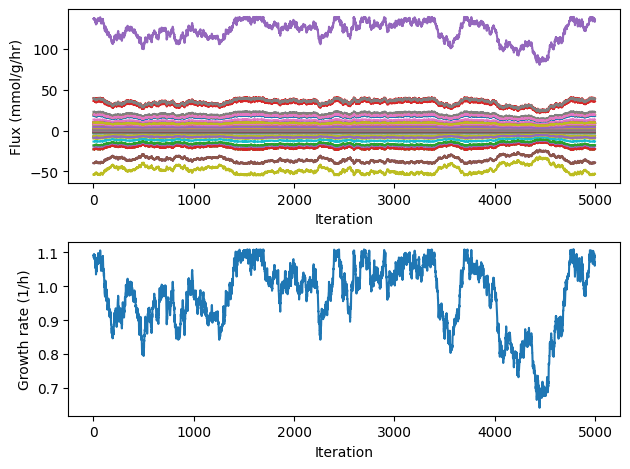

In [ ]:
rng = np.random.default_rng()

# In the future, rather than directly solving,
# should sample from the space of feasible v's with a given growth rate
samp = OptGPSampler(model)


# Initial state - just use an optimal flux distribution
with model:
    ex_glc.bounds = (-10, 0)
    v0 = model.optimize().fluxes
    names = v0.index

# Proposal - find a distribution with a similar mu
def proposal(v, sigma=0.01):
    mu = v[BIOMASS_ID]

    v_next = None
    
    while v_next is None:
        mu_next = rng.normal(0, sigma) + mu
        with model:
            ex_glc.bounds = (-10, 0)
            model.reactions.get_by_id(BIOMASS_ID).bounds = (mu_next, mu_next)
            with catch_warnings(action="ignore"):
                sol = model.optimize()
            if sol.status != "infeasible":
                return sol.fluxes

def energy(v, kT=1):
    return v[BIOMASS_ID] / kT

N_ITER = 5000
v = v0
vs = []
mus = []
for _ in tqdm(range(N_ITER)):
    cand = proposal(v)
    a = np.exp(energy(cand, kT=0.1) - energy(v, kT=0.1))
    u = rng.uniform(0, 1)
    if u <= a:
        v = cand
    
    vs.append(v.values)
    mus.append(v[BIOMASS_ID])

fig, (ax1, ax2) = plt.subplots(2, 1)
ax1.plot(vs)
ax2.plot(mus)


ax1.set_ylabel("Flux (mmol/g/hr)")
ax1.set_xlabel("Iteration")
ax2.set_ylabel("Growth rate (1/h)")
ax2.set_xlabel("Iteration")

fig.tight_layout()


(array([ 10.,  48.,  58.,  79.,  59.,  83.,  34.,  45.,  51.,  88., 196.,
        236., 279., 255., 420., 427., 507., 563., 706., 856.]),
 array([0.72991449, 0.74885279, 0.7677911 , 0.78672941, 0.80566771,
        0.82460602, 0.84354433, 0.86248264, 0.88142094, 0.90035925,
        0.91929756, 0.93823586, 0.95717417, 0.97611248, 0.99505078,
        1.01398909, 1.0329274 , 1.05186571, 1.07080401, 1.08974232,
        1.10868063]),
 <BarContainer object of 20 artists>)

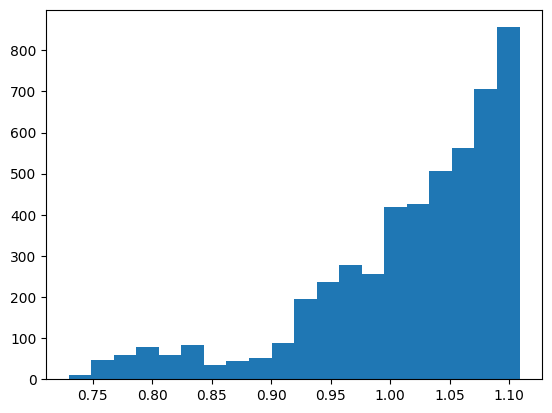

In [18]:
fig, ax = plt.subplots()

ax.hist(mus, bins=20)

In [19]:
import pandas as pd

all_vs = np.array(vs)
df = pd.DataFrame(all_vs, columns=names)
v_corr = df.corr()

In [10]:
v_corr

,1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,1.1.1.178-RXN,1.1.1.39-RXN,1.1.1.8-RXN,1.13.11.15-RXN,1.13.11.25-RXN,1.13.11.6-RXN,1.14.11.1-RXN,1.2.1.2-RXN,1.2.1.25-RXN,...,RXN-15682,RXN-20456,RXN-7931,URATE-OXIDASE-RXN,RXN-19040,RXN-11396,RXN-11063,RXN-21019,BENZALDEHYDE-DEHYDROGENASE-NADP+-RXN,RXN-20678
1-ACYLGLYCEROL-3-P-ACYLTRANSFER-RXN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.1.1.178-RXN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.1.1.39-RXN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.1.1.8-RXN,1.0,NaN,NaN,1.0,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1.13.11.15-RXN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
RXN-11396,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RXN-11063,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
RXN-21019,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
BENZALDEHYDE-DEHYDROGENASE-NADP+-RXN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


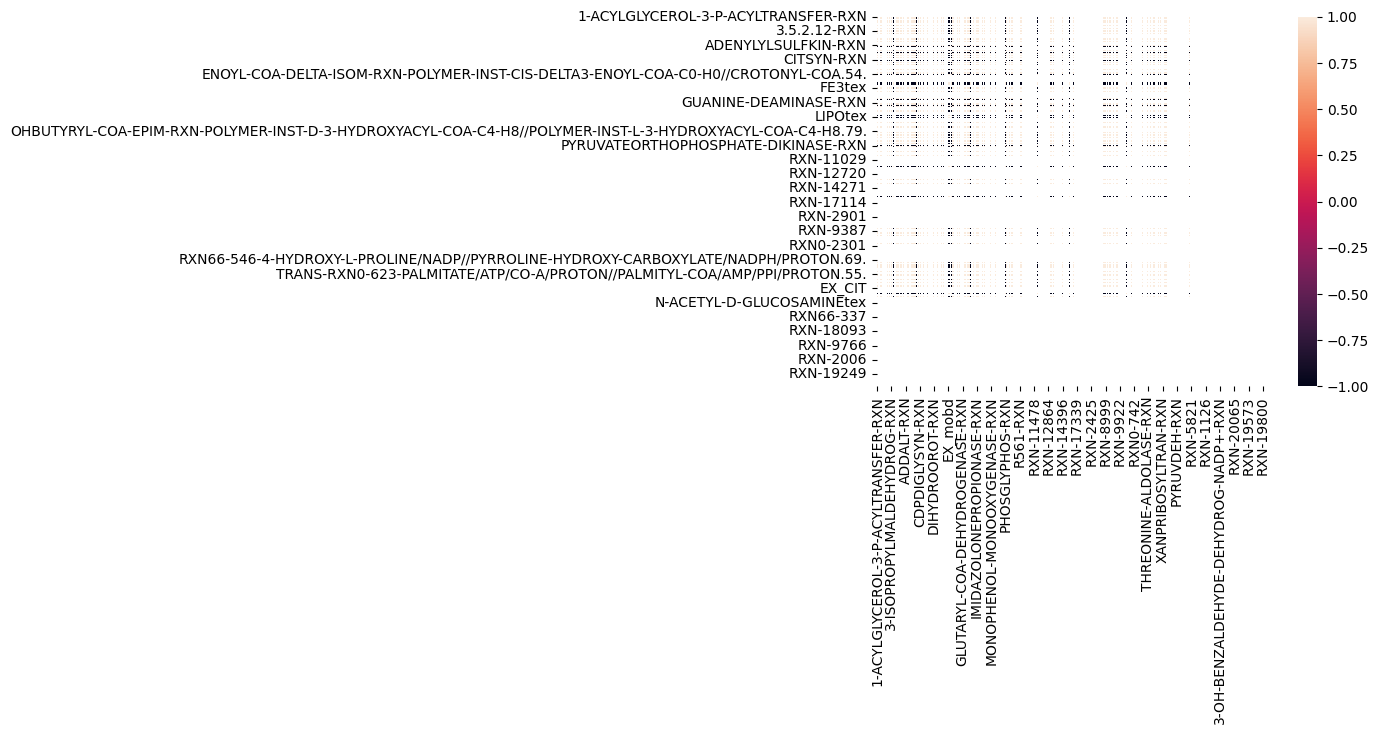

In [11]:
import seaborn as sns
sns.heatmap(v_corr, annot=False)
plt.show()